# DSU AAS 1812  - PySpark Project walk through
##  Using Python and Apache Spark to Analyze the NBA and the 3-point Shot 

https://github.com/crawles/spark-nba-analytics

 we will use season totals data from 1979 to 2016 and shot chart data to visualize how the NBA has continued to trend towards shooting more and more 3-point shots.

Using Python 3, we utilize the Spark Python API (PySpark) to create and analyze Spark [DataFrames](http://spark.apache.org/docs/latest/sql-programming-guide.html#overview). In addition, we utilize both [Spark SQL](http://spark.apache.org/docs/latest/sql-programming-guide.html#overview) and the Spark DataFrame’s [domain-specific language](http://spark.apache.org/docs/latest/sql-programming-guide.html#untyped-dataset-operations-aka-dataframe-operations) to cleanse and visualize the season total data, finally building building a simple linear regression model using [the spark.ml package](http://spark.apache.org/docs/2.0.0/api/scala/index.html#org.apache.spark.ml.package) -- Spark’s now [primary machine learning API](https://databricks.com/blog/2016/07/26/introducing-apache-spark-2-0.html). In the second half of this notebook, we utilize shot chart data to visualize the the 3-point trend.

Since the 3-point line was introduced in the 1979-80 season, there has been a steady increase in the number of 3-point shots taken. At it's core this phenomenon can be explained by the average number of points per shot. Simply put, shooting a high accuracy from three results in a very high points per shot. At the end of this post we visually demonstrate the power of the 3-point shot and its very high efficiency.

## The code

As a first step, we import `pyspark` submodules and additional packages to aid analysis including `matplotlib`, `numpy`, `pandas`, and `seaborn`.

In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import seaborn as sns

from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf

import warnings
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_color_codes()

As an optional additional step, we specify our custom plotting styles:

In [2]:
# set default plot settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 18


## Season Totals: The Rise of the 3-Point Shot

We read in the season total data from CSV, which was sourced from [Basketball Reference](http://www.basketball-reference.com/). The code for acquiring this data is located in the appendix.

Note: If you are running this with Hadoop, you will need to put the data into HDFS:<br>
`$ hadoop fs -put /home/hadoop/spark-nba-analytics/data /user/hadoop`

In [3]:
from pyspark import SparkConf, HiveContext, SparkContext
from pyspark.sql import SparkSession, Row, SQLContext
from pyspark.sql import functions as F
# Set Spark Context

conf = SparkConf()
conf.set('spark.executor.memory','20g')\
    .set('spark.yarn.queue', 'root.odfgsbx3_q1')\
    .set('spark.executor.cores','5')\
    .set('spark.executor.instances','3')\
    
spark = SparkSession.builder.appName('DSU_AAS_1812') \
    .config(conf=conf) \
    .getOrCreate()

sqlContext =  SQLContext(spark.sparkContext)

In [30]:
df = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('maprfs:///datalake/optum/optuminsight/sandbox3/dsu/nilay_bhatt/data/season_totals.csv')
# we now cache the data in memory for faster access down the line
#df.cache()

Using our DataFrame `df`, we can view the top 10 players, sorted by number of points in an individual season. Notice we use the `toPandas` function to retrieve our results. The corresponding result looks cleaner for display than when using the `take` function.  

In [7]:
df.orderBy('pts',ascending = False).limit(10)['yr','player','age','pts','fg3'].show()

+----+--------------+---+----+---+
|  yr|        player|age| pts|fg3|
+----+--------------+---+----+---+
|1987|Jordan,Michael| 23|3041| 12|
|1988|Jordan,Michael| 24|2868|  7|
|2006|   Bryant,Kobe| 27|2832|180|
|1990|Jordan,Michael| 26|2753| 92|
|1989|Jordan,Michael| 25|2633| 27|
|2014|  Durant,Kevin| 25|2593|192|
|1980| Gervin,George| 27|2585| 32|
|1991|Jordan,Michael| 27|2580| 29|
|1982| Gervin,George| 29|2551| 10|
|1993|Jordan,Michael| 29|2541| 81|
+----+--------------+---+----+---+



We can also view the column names of our DataFrame:

In [8]:
print(df.columns)

['_c0', 'player', 'pos', 'age', 'team_id', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'fg2', 'fg2a', 'fg2_pct', 'efg_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'yr']


Next, we can analyze the number of 3 point attempts taken each season computing the average attempts [per 36 minutes](http://www.basketball-reference.com/leagues/NBA_2016_per_minute.html) for each season.

In [31]:
# 3 point attempts / 36 minute
fga_py = df.groupBy('yr')\
           .agg({'mp' : 'sum', 'fg3a' : 'sum'})\
           .select(col('yr'), (36*col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_p36m'))\
           .orderBy('yr')
fga_py.show()

+----+-------------------+
|  yr|          fg3a_p36m|
+----+-------------------+
|1980|0.41008926195402606|
|1981|   0.30937598914296|
|1982|0.34151142956708874|
|1983|0.33147855170629886|
|1984| 0.3571099981210193|
|1985|0.46373268657964656|
|1986| 0.5048495566299677|
|1987| 0.6930178408483056|
|1988| 0.7616836428999401|
|1989| 0.9726163179963269|
|1990| 0.9661025847435382|
|1991| 1.0510534659428055|
|1992| 1.1255810772628043|
|1993| 1.3226586419607964|
|1994| 1.4581127615644094|
|1995|  2.301665858459081|
|1996| 2.3480804835419544|
|1997|  2.505318518120279|
|1998| 1.9234008875321518|
|1999| 1.9658030724939282|
+----+-------------------+
only showing top 20 rows



Alternatively, we can utilize Spark SQL to perform the same query using plain SQL syntax:

In [10]:
# or could use SQL
sqlContext.registerDataFrameAsTable(df, 'df')
fga_py = sqlContext.sql('''SELECT yr,
                                  sum(fg3a)/sum(mp)*36 fg3a_p36m
                           FROM df GROUP BY yr
                           ORDER BY yr''')

Now that we have aggregated our data and computed the average per 36 minute attempts for each season, we can query our results into a Pandas DataFrame and plot it using `matplotlib`. 

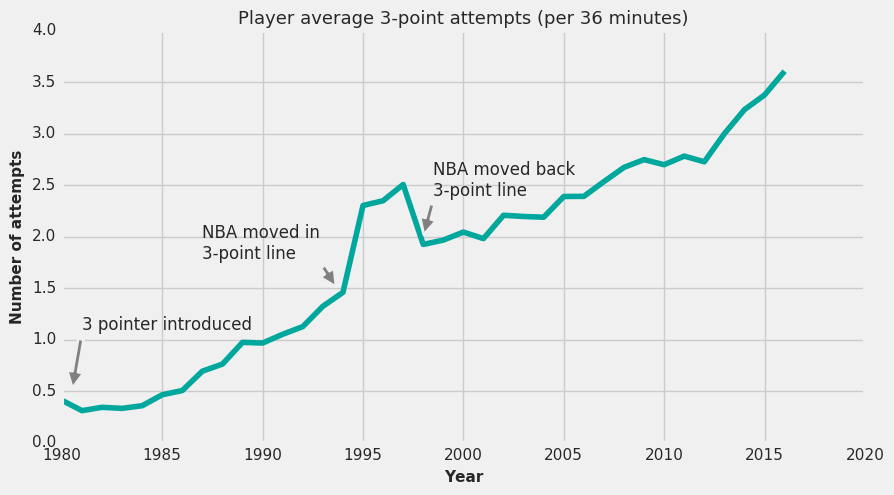

In [11]:
_df = fga_py.toPandas()
plt.plot(_df.yr,_df.fg3a_p36m, color = '#00a79c')
plt.xlabel('Year')
plt.ylabel('Number of attempts')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
_=plt.annotate('3 pointer introduced', xy=(1980.5, .5), xytext=(1981, 1.1), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved in\n3-point line', xy=(1993.7, 1.5), xytext=(1987, 1.79), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved back\n3-point line', xy=(1998, 2.), xytext=(1998.5, 2.4), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.tight_layout()
plt.savefig('results/3_point_trend.png')

We can see a steady rise in the number of 3 point attempts since the shot's introduction in the 1979-80 season. It's interesting and logical to observe the the blip in number of attempts during the period in the mid 90's when the NBA moved the line in a few feet. In addition, there has also been a more sudden rise in the number of attempts in the past 5 years.

## Building a linear regression model

We can fit a linear regression model to this curve to model the increase in shot attempts and also to make a  prediction for the next 5 years. Of course, this assumes a linear nature of the rate of increase and is likely a naive assumption. 

Firstly, we must transform our data using the `VectorAssembler` function to a single column where each row consists of a feature vector. This is a requirement for the linear regression function in ML Pipelines. We first build the transformer using our single variable `yr` and transform our season total data using the transformer function.

In [12]:
# train the model
t = VectorAssembler(inputCols=['yr'], outputCol = 'features')
training = t.transform(fga_py)\
            .withColumn('yr',fga_py.yr)\
            .withColumn('label',fga_py.fg3a_p36m)
training.toPandas().head()

,yr,fg3a_p36m,features,label
0,1980,0.410089,[1980.0],0.410089
1,1981,0.309376,[1981.0],0.309376
2,1982,0.341511,[1982.0],0.341511
3,1983,0.331479,[1983.0],0.331479
4,1984,0.357110,[1984.0],0.357110


We then build our linear regression model object using our transformed data.

In [13]:
lr = LinearRegression(maxIter=10)
model = lr.fit(training)

Next, we want to apply our trained model object `model` to our original training set along with 5 years of future data. Spanning this date frame, we build a test DataFrame, transform it to features, and then apply our model to make a prediction.

In [16]:
# apply model for the 1979-80 season thru 2020-21 season
training_yrs = training.select('yr').rdd.map(lambda x: x[0]).collect()
training_y = training.select('fg3a_p36m').rdd.map(lambda x: x[0]).collect()
prediction_yrs = [2017, 2018, 2019, 2020, 2021]
all_yrs = training_yrs + prediction_yrs

# built testing DataFrame
test_rdd = spark.sparkContext.parallelize(all_yrs)
row = Row('yr')
all_years_features = t.transform(test_rdd.map(row).toDF())

# apply linear regression model
df_results = model.transform(all_years_features).toPandas()

We can then plot our results:

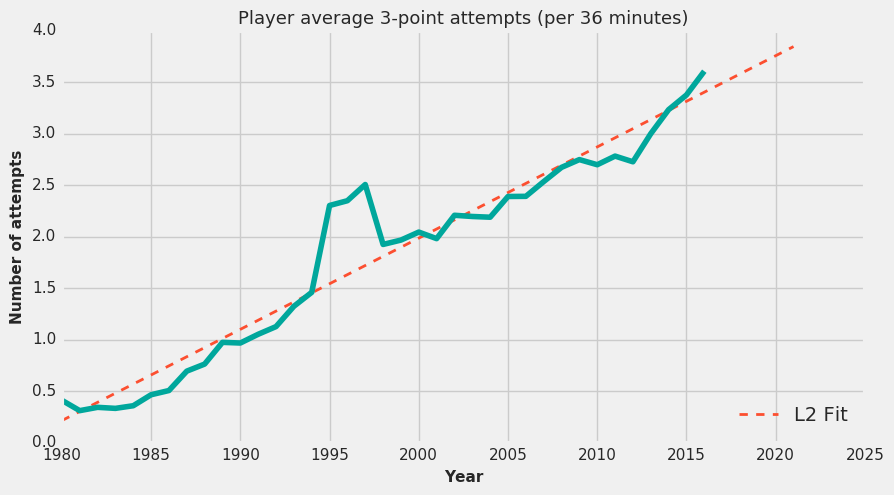

In [17]:
plt.plot(df_results.yr,df_results.prediction, linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'L2 Fit')
plt.plot(training_yrs, training_y, color = '#00a79c', label = None)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.tight_layout()
plt.savefig('results/model_prediction.png')

## Shot chart data

In addition to season total data, we process and analyze NBA shot charts to view the impact the 3-point revolution has had on shot selection. The shot chart data was acquired from [nbasavant.com](https://www.nbasavant.com), which sources it's data from NBA.com and ESPN.

The shot chart data contains xy coordinates of field goal attempts for individual players, game date, time of shot, shot distance, a shot made flag, and other fields. We have compiled all individual seasons where a player attempted at least 1000 field goals attempts from the 2010-11 through the 2015-16 season.

As before we can read in the CSV data into a Spark DataFrame.

In [18]:
# reset style for pretty shot charts
plt.style.use('default')
sns.set_style("white")

df = spark.read\
          .option('header', 'true')\
          .option('inferSchema', 'true')\
          .csv('maprfs:///datalake/optum/optuminsight/sandbox3/dsu/nilay_bhatt/data/shot_charts_top_10/1000_plus_shot_charts_2011_2016.csv')
df.cache() # optimizes performance for later calls to this dataframe
print(df.count())
df.orderBy('game_date').limit(10).toPandas()[['yr','name','game_date','shot_distance','x','y','shot_made_flag']]

243719


,yr,name,game_date,shot_distance,x,y,shot_made_flag
0,2011,LaMarcus Aldridge,2010-10-26,1,4,11,0
1,2011,Paul Pierce,2010-10-26,25,67,246,1
2,2011,Paul Pierce,2010-10-26,18,165,83,0
3,2011,Paul Pierce,2010-10-26,24,159,186,0
4,2011,Paul Pierce,2010-10-26,24,198,148,1
5,2011,Paul Pierce,2010-10-26,23,231,4,1
6,2011,Paul Pierce,2010-10-26,1,-7,9,0
7,2011,Paul Pierce,2010-10-26,0,-2,-5,1
8,2011,LaMarcus Aldridge,2010-10-26,21,39,211,0
9,2011,LaMarcus Aldridge,2010-10-26,8,-82,23,0


We can query an individual player and season and visualize their shots locations. We utilize code based on Savvas Tjortjoglou's [wonderful example](http://savvastjortjoglou.com/nba-shot-sharts.html).

As an example, we visualize Steph Curry's 2015-2016 historic shooting season using a hexbin plot.

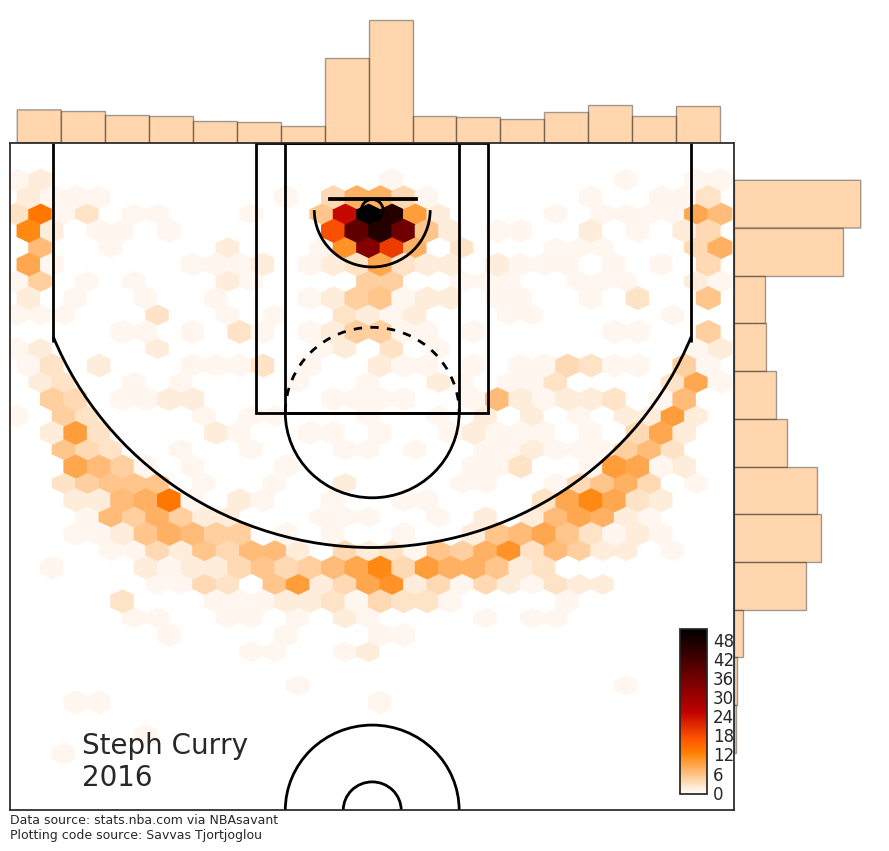

In [19]:
player = 'Stephen Curry'
yr = '2016'
df_steph = df.filter('''name == "{player}"
                        and yr == {yr}
                        and y < 400'''.format(player = player,
                                              yr = yr))
x = np.array([v[0] for v in df_steph.select('x').collect()])
y = np.array([v[0] for v in df_steph.select('y').collect()])
p=plot_shot_chart(x, y, gridsize = 30,
                      kind='hex',
                      label='Steph Curry\n2016')
p.savefig('results/steph_curry_2016_shotchart.png')

The shot chart data is rich in information, but it does not specify if a given shot is a 3-point attempt, not to mention if the shot is a corner 3. Not to worry! We can utilize Spark's User Defined Functions (UDF) to assign a classification to every shot.

Here we defined our shot classification functions using standard Python functions even utilizing `numpy` routines as well.

In [20]:
def is_corner_3(xy):
    '''Want to identify corner 3 point attempts'''
    x,y = xy
    return int((abs(x) >= 220) and (y < 92.5))

def is_normal_3(xycorner3):
    '''Want to identify normal (not corner 3) point attempts'''
    x,y,corner3 = xycorner3
    radius = 475/2.
    y_3pt = np.sqrt(np.square(radius) - np.square(x))
    return int(y > max(92.5,y_3pt) and not corner3)

We then register our UDFs and apply each UDF to the entire dataset to classify each shot type:

In [21]:
corner_3_udf = udf(is_corner_3, IntegerType())
normal_3_udf = udf(is_normal_3, IntegerType())

df2 = df.withColumn('corner_3', corner_3_udf(array([df.x,df.y])))
df3 = df2.withColumn('normal_3', normal_3_udf(array([df2.x,df2.y,df2.corner_3])))
df4 = df3.withColumn('is_a_3', df3.corner_3 + df3.normal_3) 

df = df4
df.cache()

DataFrame[_c0: int, yr: int, name: string, team_name: string, game_date: timestamp, season: int, espn_player_id: int, team_id: int, espn_game_id: double, period: int, minutes_remaining: int, seconds_remaining: int, shot_made_flag: int, action_type: string, shot_type: string, shot_distance: int, opponent: string, x: int, y: int, dribbles: double, touch_time: double, defender_name: string, defender_distance: double, shot_clock: double, corner_3: int, normal_3: int, is_a_3: int]

In [23]:
df.show(5)

+---+----+--------------+---------------+-------------------+------+--------------+----------+------------+------+-----------------+-----------------+--------------+--------------------+--------------+-------------+------------------+---+---+--------+----------+-------------+-----------------+----------+--------+--------+------+
|_c0|  yr|          name|      team_name|          game_date|season|espn_player_id|   team_id|espn_game_id|period|minutes_remaining|seconds_remaining|shot_made_flag|         action_type|     shot_type|shot_distance|          opponent|  x|  y|dribbles|touch_time|defender_name|defender_distance|shot_clock|corner_3|normal_3|is_a_3|
+---+----+--------------+---------------+-------------------+------+--------------+----------+------------+------+-----------------+-----------------+--------------+--------------------+--------------+-------------+------------------+---+---+--------+----------+-------------+-----------------+----------+--------+--------+------+
|  0|20

##  Shot attempts have changed in the past 6 years

We can visualize the change in the shot selection using all of our data from the 2010-11 season up until the 2015-16 season. For visualization purposes, we exclude all shot attempts taken inside of 8 feet as we would like to focus on the midrange and 3 point shots. An accompanying trend to the increase of 3-point shots is the decrease in midrange attempts and this can be visualized as well.

TypeError: slice indices must be integers or None or have an __index__ method

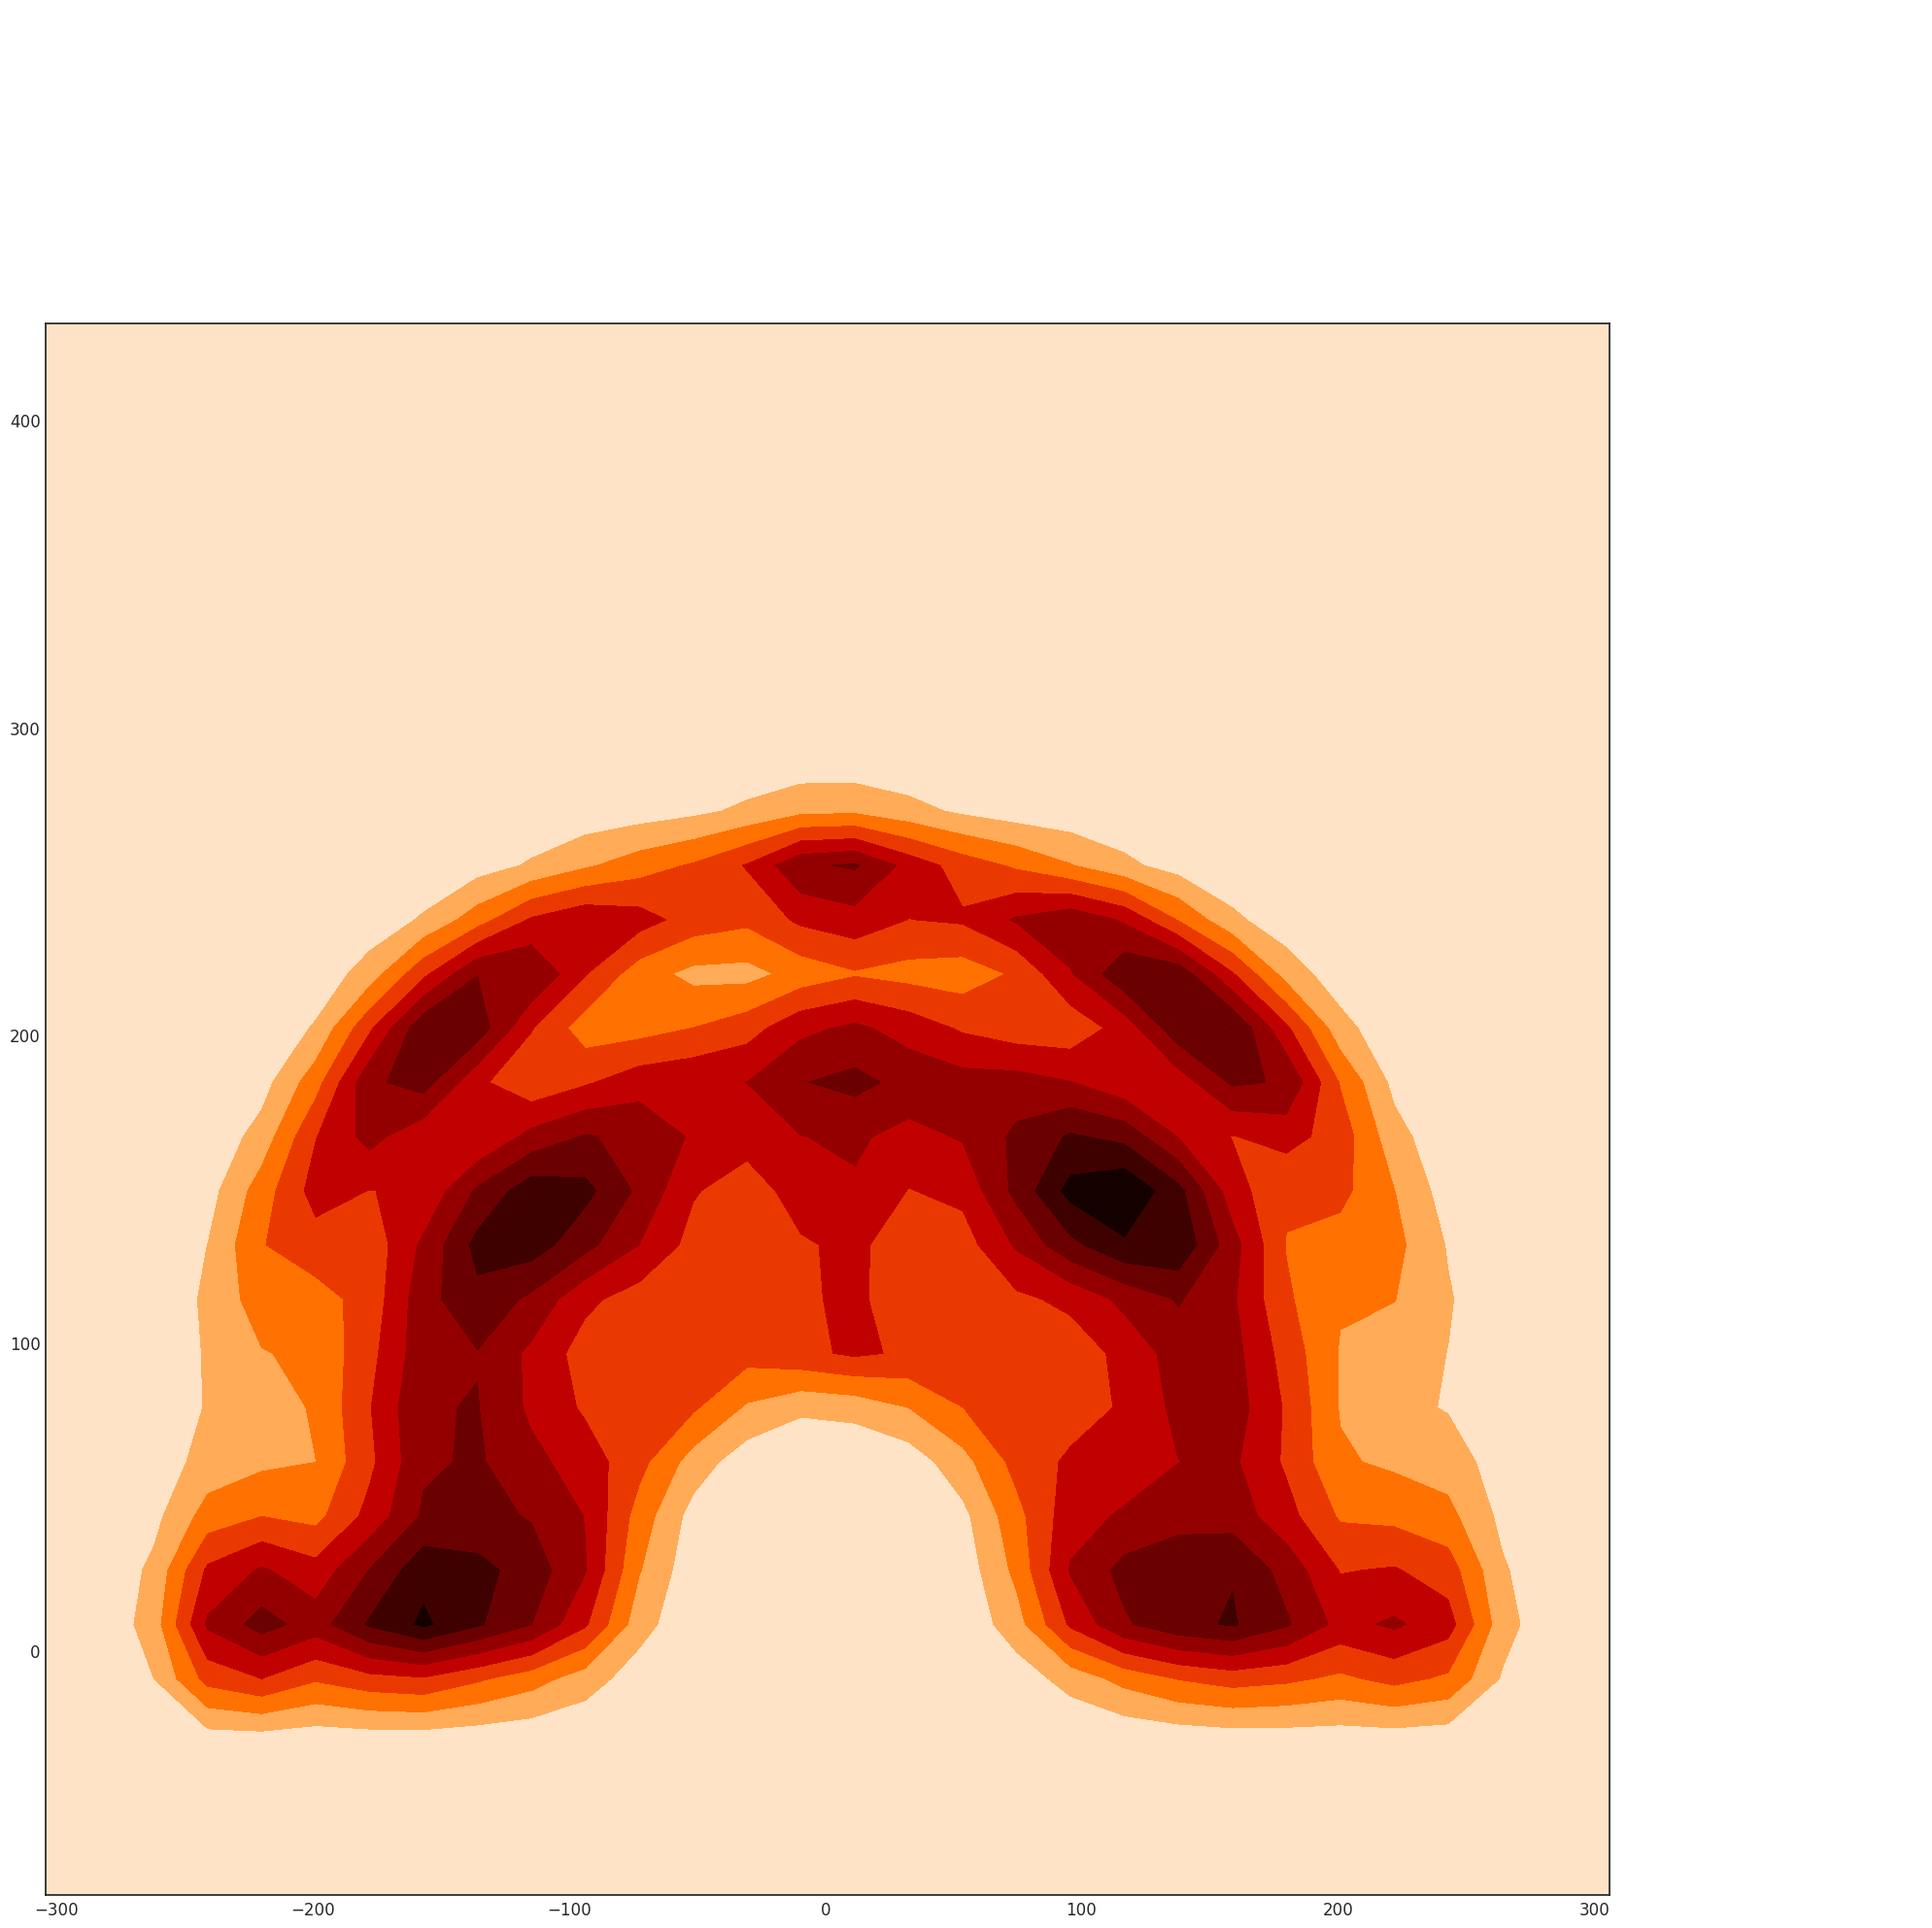

In [28]:
# make shot charts for all years
midrange_thresh = 8
in_half_court = 'y <= 400 and abs(x) <= 250' 
addl_filter = 'shot_distance > {midrange_thresh}'.format(midrange_thresh = midrange_thresh)
for yr in range(2011,2016+1):
    df_yr = df.filter('''{in_half_court}
                         and yr == {yr}
                         and {addl_filter}'''.format(in_half_court = in_half_court,
                                                     yr = yr,
                                                     addl_filter = addl_filter))
    x = np.array([v[0] for v in df_yr.select('x').collect()])
    y = np.array([v[0] for v in df_yr.select('y').collect()])
    p = plot_shot_chart(x,y, gridsize = 30, kind = 'kde', label = yr)
    p.fig.suptitle('Evolution of the 3 point shot', x = .19, y = 0.86, size = 20, fontweight= 'bold')
    
    per_3 = df_yr.select(mean(df_yr.is_a_3)).take(1)[0][0]
    per_midrange = 1 - per_3
    draw_3pt_piechart(per_3, per_midrange)
    
    p.savefig('results/all_years/{}.png'.format(yr))
    plt.close()

![title](results/all_years/2012.png)

After we generate shot charts for each year, we create an animated gif using the ImageMagick `convert` routine:

In [47]:
# convert to gif
!convert -delay 200 -loop 0 results/all_years/*.png results/evolution_3pt.gif

<img src='results/evolution_3pt.gif'> 

Over the years, there is a notable trend towards more three pointers and less midrange shots.

## Points per shot

Finally, we end with where we started. The motivating factor and the math behind the efficiency of the 3 point shot can be attributed to its very high points per shot. The simple math means that shooting 33% on 3-point shots is equal to shooting 50% on 2-point shots. Thus high percentage 3-pointers can be very valuable shots.

We compute the points per shot vs. distance on our shot chart dataset:

In [48]:
shot_acc = df.groupBy('shot_distance','corner_3','normal_3','is_a_3')\
             .agg(count('*').alias('num_attempts'),mean(df.shot_made_flag).alias('shot_accuracy'))\
             .withColumn('points_per_shot',when(col('is_a_3') == 1, col('shot_accuracy')*3)
                                           .otherwise(col('shot_accuracy')*2)
                        )\
             .filter('num_attempts > 5')\
             .orderBy('shot_distance')\
             .toPandas()

We then the plot points per shot vs. shot distance:

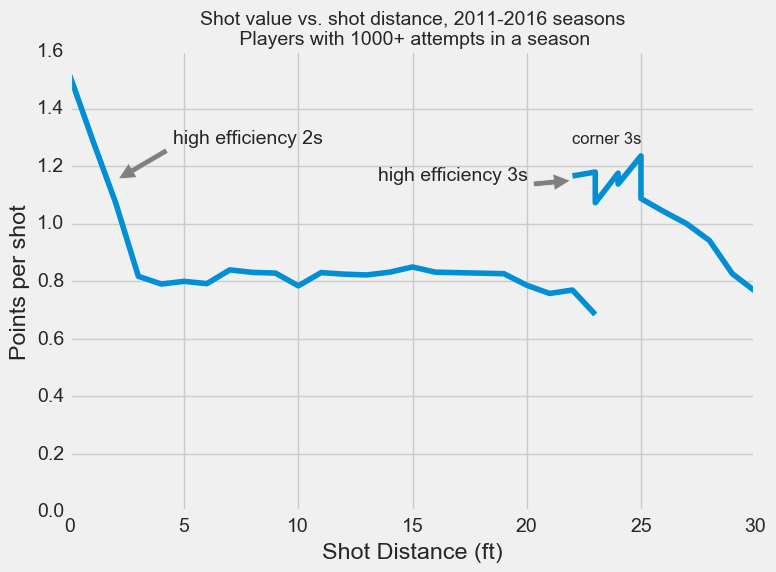

In [55]:
plt.style.use('fivethirtyeight')

def plot_acc_vs_dist(df,kwargs = {}):
    plt.plot(df.shot_distance, df.points_per_shot, **kwargs)
    
plot_acc_vs_dist(shot_acc.query('is_a_3 == False'), {'color' : '#008fd5'})
plot_acc_vs_dist(shot_acc.query('is_a_3 == True'), {'color' : '#008fd5'})
plt.title('Shot value vs. shot distance, 2011-2016 seasons\n Players with 1000+ attempts in a season', size = 14)
plt.xlim(0,30)
plt.xlabel('Shot Distance (ft)')
plt.ylabel('Points per shot')
plt.annotate('high efficiency 2s', xy=(2., 1.15), xytext=(4.5, 1.28),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            )
plt.annotate('high efficiency 3s', xy=(22, 1.15), xytext=(13.5, 1.15),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            )
plt.text(22, 1.28, 'corner 3s', fontsize = 12)
plt.tight_layout()
plt.savefig('results/pps.png')

Among the top scorers in the league, corner 3 and other close 3-point attempts are among the most efficient shots in the league and are on par with shots taken within just a few feet of the basket. It's no wonder that accurate 3-point shooting is among the most valuable talents in the NBA today!

# Appendix

## Scrape season totals

Using Beautiful Soup, we scrape the season totals for every player from the 1979-1980 season up until the 2015-2016 season.

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
def parse_html_table(html_table):
    '''For parsing basketball reference stats html table.
    We will apply this function to every seasons html page.'''
    data = []
    cur_row = []
    row_names = []
    for ele in html_table:
        stat_name  = ele['data-stat']
        stat_value = ele.string
        new_row = (stat_name == 'player')
        if new_row:
            if cur_row:
                data.append(cur_row)
            cur_row = []
            col_names = []
            cur_row.append(ele['csk']) # fixes weird asterisk error
            col_names.append(stat_name)
            continue
        cur_row.append(stat_value)
        col_names.append(stat_name)
    return data, col_names

In [ ]:
# # Loop thru each year and collect data
# dfs = []
# for yr in range(1980,(2016 + 1)):
#     url = 'http://www.basketball-reference.com/leagues/NBA_{yr}_totals.html'.format(yr = yr)
#     r = requests.get(url)
#     soup = BeautifulSoup(r.text)
#     yr_data, col_names = parse_html_table(soup.findAll('td'))
#     df = pd.DataFrame(yr_data, columns = col_names)
#     df['yr'] = yr
#     dfs.append(df)
# all_seasons = pd.concat(dfs)
# all_seasons.to_csv('data/season_totals.csv')